<a href="https://colab.research.google.com/github/awesome786engineer/Machine-Learning-Projects/blob/main/InstaFakeID_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# code starts here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True )

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/fake_insta/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/fake_insta/test.csv')

In [ ]:
len(train_df.columns)

12

In [ ]:
train_df.head()


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [ ]:
test_df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


Here "nums/length" and nums/length_full_name" is ratio of numerical characters in its user name and its full name

In [ ]:
# test_df.isna().sum()

In [ ]:
#train_df.isnull().sum()

## MLWorkFLow ##

1. Data preprocessing used

    -  missing numerical values were replaced by mediian values reducing effect of  outliers
    -  missing categorical values(eg profile picture ) were replaced with mode  
2. Data transformation

    - apply one hot encoding for features "profile pic","private","external URL", presence = 1, absence = 0

3. Outlier Detection and Removal
    
    - use interquartile range or z- score method to detect and remove outlier that might skew the model performance

4. Feature selection

    - to avoid multicollinearity using "CORRELATION MATRIX"
    - lasso (L1) regularization to select importnat features by shrinking the less important features coefficients to zero
    - use RECURSIVE FEATURE ELEMINATION to select top performin features by iteratively training and eliminating weaker features

5. Normalization

    - normalize high performing features

6. Model building using
    - for now logistic regression only
    - later implement 1. KNN ,2. Random Forest,3. SVC(support vector classifier)




# OUTLIER DETECTION AND REMOVAL #

In [ ]:
# plot the distribution of all numeric features
binary_columns = ["profile pic","name==username","external URL","private","fake"]
non_binary_columns = [col for col in train_df.columns if col not in binary_columns]

In [ ]:
len(non_binary_columns)

7

In [ ]:
non_binary_columns

['nums/length username',
 'fullname words',
 'nums/length fullname',
 'description length',
 '#posts',
 '#followers',
 '#follows']

In [ ]:
# for i in range(5):
#   sns.histplot(data = train_df,x = non_binary_columns[i],kde = True)
#   plt.show()

In [ ]:
# calculating skewness of all the attributes
train_df[non_binary_columns].skew()

,0
nums/length username,1.262902
fullname words,3.324440
nums/length fullname,4.436645
description length,1.866800
#posts,12.986196
#followers,13.679045
#follows,4.724968


In [ ]:
train_df.corr()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
profile pic,1.000000,-0.364087,0.213295,-0.131756,-0.124903,0.367892,0.236729,0.114732,0.169570,0.061137,0.194833,-0.637315
nums/length username,-0.364087,1.000000,-0.225472,0.408567,0.056890,-0.321170,-0.237125,-0.063713,-0.157442,-0.062785,-0.172413,0.587687
fullname words,0.213295,-0.225472,1.000000,-0.094348,-0.082969,0.272522,0.196562,-0.089070,0.073350,0.033225,0.094855,-0.298793
nums/length fullname,-0.131756,0.408567,-0.094348,1.000000,0.291149,-0.117521,-0.088724,-0.030030,-0.057716,-0.027035,-0.067971,0.246782
name==username,-0.124903,0.056890,-0.082969,0.291149,1.000000,-0.064814,-0.039232,0.046084,-0.049808,-0.017761,-0.009529,0.170695
description length,0.367892,-0.321170,0.272522,-0.117521,-0.064814,1.000000,0.482313,-0.110329,0.144824,0.005929,0.226561,-0.460825
external URL,0.236729,-0.237125,0.196562,-0.088724,-0.039232,0.482313,1.000000,-0.162612,0.165008,0.027189,0.142519,-0.362809
private,0.114732,-0.063713,-0.089070,-0.030030,0.046084,-0.110329,-0.162612,1.000000,-0.087495,-0.073473,-0.057542,-0.028586
#posts,0.169570,-0.157442,0.073350,-0.057716,-0.049808,0.144824,0.165008,-0.087495,1.000000,0.321385,0.098225,-0.245355
#followers,0.061137,-0.062785,0.033225,-0.027035,-0.017761,0.005929,0.027189,-0.073473,0.321385,1.000000,-0.011066,-0.093689


In [ ]:
selected_columns = ['profile pic','nums/length username','fullname words','description length','external URL']

# Applying IQR range for Outlier Detection #

In [ ]:
# making box plot for all the non_binary columns
# for col in non_binary_columns:
#   train_df.boxplot(column = col)
#   plt.show()

## capping the outliers #

In [ ]:
new_train_df = train_df.copy()
new_test_df = test_df.copy()

In [ ]:
def filter_iqr(original_df,col,new_df,train = True):
  Q1 = original_df[col].quantile(0.25)
  Q3 = original_df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR
  if train:
    new_df[col] = original_df[col].clip(lower = lower_limit ,upper = upper_limit)
  else:
    new_df[col] = test_df[col].clip(lower = lower_limit ,upper = upper_limit)
  return (lower_limit,upper_limit)


In [ ]:
from collections import defaultdict
quartile_limits = defaultdict(tuple)
for col in non_binary_columns:
  quartile_limits[col] = filter_iqr(train_df,col,new_train_df)
  filter_iqr(train_df,col,new_test_df,train = False)

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))

profile pic : ()
nums/length username : (np.float64(-0.46499999999999997), np.float64(0.7749999999999999))
fullname words : (np.float64(-0.5), np.float64(3.5))
description length : (np.float64(-51.0), np.float64(85.0))
external URL : ()


In [ ]:
new_train_df[non_binary_columns].skew()

,0
nums/length username,1.097140
fullname words,0.439757
nums/length fullname,0.000000
description length,1.289921
#posts,1.245706
#followers,1.270007
#follows,1.188118


In [ ]:
new_test_df[non_binary_columns].skew()

,0
nums/length username,1.058423
fullname words,0.719970
nums/length fullname,0.000000
description length,1.037544
#posts,1.657328
#followers,1.512365
#follows,0.958544


# Applying Logistic regression on IQR filtered data #

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train = new_train_df.drop('fake',axis = 1)
y_train = new_train_df['fake']
X_test = new_test_df.drop('fake',axis = 1)
y_test = new_test_df['fake']


# Logistic regression without sklearn #

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [ ]:
def compute_cost_vectorized(X, w, b, y):
  m = X.shape[0]
  z = X @ w + b  # (m,n) @ (n,) -> (m,). Vectorized dot product for all examples!
  f_wb = sigmoid(z) # (m,) vector of all predictions

  # Element-wise operations on the entire vectors
  cost = -y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)
  total_cost = np.sum(cost) / m

  return total_cost


In [ ]:
def gradient_functions_vectorized(X, w, b, y):
  m, n = X.shape
  z = X @ w + b      # (m,) vector of z for all examples
  f_wb = sigmoid(z)  # (m,) vector of all predictions

  error = f_wb - y   # (m,) vector of all errors

  # (m,) * (m, n) is not what we want. We need (n,) result.
  # So we do (n, m) @ (m,) -> (n,)
  dj_dw = (X.T @ error) / m # transpose of X(m,n) is X.T(n,m)
  dj_db = np.sum(error) / m

  return dj_dw, dj_db

In [ ]:
def train_vectorized(X, y, alpha, num_iters):
  cost_history =[]
  w = np.zeros(X.shape[1])
  b = 0
  for i in range(num_iters):
    dj_dw, dj_db = gradient_functions_vectorized(X, w, b, y)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i % 1000 == 0: # Check cost less frequently to save time
        cost = compute_cost_vectorized(X, w, b, y)
        cost_history.append(cost)
        print(f"Iteration {i:5d}: Cost {cost:0.4f}")

  return w, b, cost_history


In [ ]:
def predict_vectorized(X, w, b):
  z = X @ w + b
  f_wb = sigmoid(z)
  p = f_wb >= 0.5 # Creates a boolean array
  return p.astype(int)

In [ ]:
#w, b,cost_history = train(X_train[selected_columns].values,y_train,0.01,15000)

In [ ]:
w, b,cost_history = train_vectorized(X_train[selected_columns].values,y_train,0.01,15000)

Iteration     0: Cost 0.6149
Iteration  1000: Cost 0.4768
Iteration  2000: Cost 0.4251
Iteration  3000: Cost 0.3922
Iteration  4000: Cost 0.3696
Iteration  5000: Cost 0.3532
Iteration  6000: Cost 0.3407
Iteration  7000: Cost 0.3309
Iteration  8000: Cost 0.3230
Iteration  9000: Cost 0.3164
Iteration 10000: Cost 0.3108
Iteration 11000: Cost 0.3060
Iteration 12000: Cost 0.3019
Iteration 13000: Cost 0.2982
Iteration 14000: Cost 0.2950


In [ ]:
y_pred = predict_vectorized(X_test[selected_columns].values,w,b)

In [ ]:
accuracy_score(y_test,y_pred)

0.9

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        60
           1       0.94      0.85      0.89        60

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



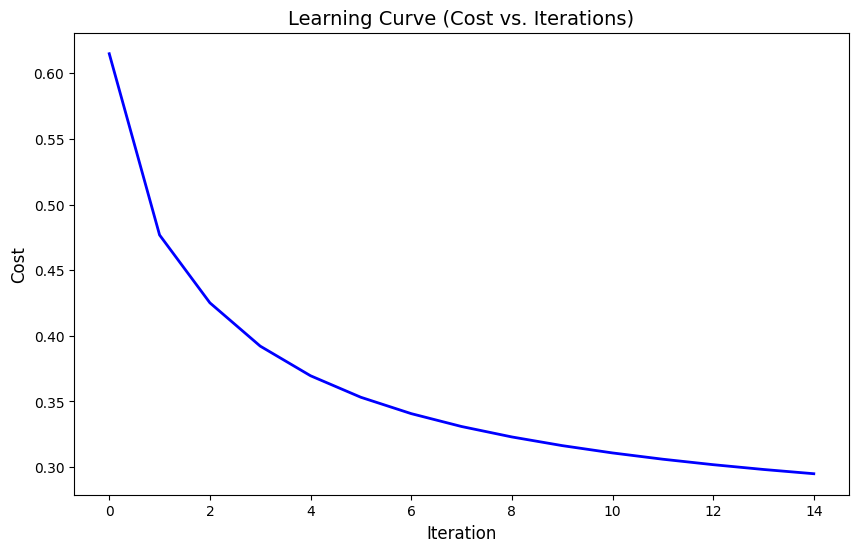

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(cost_history)),  # X-axis: iteration numbers (0 to 9999)
    cost_history,              # Y-axis: cost values
    color='blue',
    linestyle='solid',
    linewidth=2
)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Learning Curve (Cost vs. Iterations)', fontsize=14)
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        60
           1       0.94      0.85      0.89        60

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [ ]:
w,b

(array([-2.80260132,  3.60909299, -0.35848741, -0.02805083, -1.33505898]),
 np.float64(2.659345278516535))

In [ ]:
# testing on real account
w = np.array([-2.80260132,  3.60909299, -0.35848741, -0.02805083, -1.33505898])
b = 2.659345278516536

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))